In [1]:
from mmdet.datasets import CocoDataset
import json
import os
import random
import numpy as np

In [2]:
def save_label_noise_annots(dname):
    ann_file = f'/mnt/ssd2/sc_datasets_det/{dname}/annotations/instances_train_16_1.json'

    with open(ann_file, "r") as fp:
        anno = json.load(fp)

    print("dname", dname)
    print("ann_file", ann_file)
    print("len image", len([img for img in anno["images"]]))
    print("len annotations", len([ann["id"] for ann in anno["annotations"]]))

    annots = anno["annotations"]

    N = len(annots)
    M = max(int(N * 0.05), 2)
    print(f"N={N}, M={M}")

    random.shuffle(annots)

    no_set = annots[:M]
    ok_set = annots[M:]

    images = {ann["id"]: ann for ann in anno["images"]}

    dxdys = [np.array([1, 0]), np.array([0, 1]), np.array([1, 1]), np.array([1, -1])]
    dxdys = dxdys + [-dxdy for dxdy in dxdys]

    cat_ids = np.unique([ann["category_id"] for ann in annots])

    def _move_bbox(ann, delta = 0.4):
        img_w, img_h = images[ann["image_id"]]["width"], images[ann["image_id"]]["height"]
            
        x, y, w, h = ann["bbox"]
        # x1, y1, x2, y2 = x, y, x + w, y + h
        wh = np.array([w, h])

        dxdy = random.choice(dxdys)
        dxdy = 0.4 * wh * dxdy
        
        x1y1 = np.array([x, y]) + dxdy
        x2y2 = x1y1 + wh

        x1, y1 = x1y1
        x2, y2 = x2y2

        x1 = np.clip(x1, 0, img_w)
        x2 = np.clip(x2, 0, img_w)
        y1 = np.clip(y1, 0, img_h)
        y2 = np.clip(y2, 0, img_h)

        ann["bbox"] = [x1, y1, x2 - x1, y2 - y1]
        ann["noise"] = 1
        # assert x2 - x1 == w, f"x2={x2}, x1={x1}, w={w}"
        # assert y2 - y1 == h, f"y2={y2}, y1={y1}, h={h}"

    def _change_label(ann):
        id = ann["category_id"]
        new_id = random.choice(cat_ids)
        while id == new_id:
            new_id = random.choice(cat_ids)

        ann["category_id"] = new_id.item()
        ann["noise"] = 2

    for idx, ann in enumerate(no_set):
        if idx < M // 2:
            _move_bbox(ann)
        else:
            _change_label(ann)

    for ann in ok_set:
        ann["noise"] = 0

    anno["annotations"] = no_set + ok_set

    dir_path, fname = os.path.split(ann_file)
    name, ext = os.path.splitext(fname) 

    new_fpath = os.path.join(dir_path, name + "_noise" + ext)

    with open(new_fpath, "w") as fp:
        json.dump(anno, fp)
        print(new_fpath)
    
    print("Save to", new_fpath)

In [3]:
# # dname = "aerial-maritime"
# dname = "pklot"
# # dname = "d6-dice"
# # dname = "bccd"

for dname in ["aerial-maritime", "pklot", "d6-dice", "bccd"]:
    save_label_noise_annots(dname)

dname aerial-maritime
ann_file /mnt/ssd2/sc_datasets_det/aerial-maritime/annotations/instances_train_16_1.json
len image 16
len annotations 53
N=53, M=2
/mnt/ssd2/sc_datasets_det/aerial-maritime/annotations/instances_train_16_1_noise.json
Save to /mnt/ssd2/sc_datasets_det/aerial-maritime/annotations/instances_train_16_1_noise.json
dname pklot
ann_file /mnt/ssd2/sc_datasets_det/pklot/annotations/instances_train_16_1.json
len image 16
len annotations 1024
N=1024, M=51
/mnt/ssd2/sc_datasets_det/pklot/annotations/instances_train_16_1_noise.json
Save to /mnt/ssd2/sc_datasets_det/pklot/annotations/instances_train_16_1_noise.json
dname d6-dice
ann_file /mnt/ssd2/sc_datasets_det/d6-dice/annotations/instances_train_16_1.json
len image 16
len annotations 96
N=96, M=4
/mnt/ssd2/sc_datasets_det/d6-dice/annotations/instances_train_16_1_noise.json
Save to /mnt/ssd2/sc_datasets_det/d6-dice/annotations/instances_train_16_1_noise.json
dname bccd
ann_file /mnt/ssd2/sc_datasets_det/bccd/annotations/insta

1024

N=1024, M=51


/mnt/ssd2/sc_datasets_det/pklot/annotations/instances_train_noise.json


In [8]:
img_size = (992, 736)
img_norm_cfg = dict(mean=[0, 0, 0], std=[255, 255, 255], to_rgb=True)

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='MinIoURandomCrop',
        min_ious=(0.1, 0.3, 0.5, 0.7, 0.9),
        min_crop_size=0.3),
    dict(
        type='Resize',
        img_scale=[(992, 736), (896, 736), (1088, 736), (992, 672), (992, 800)],
        multiscale_mode='value',
        keep_ratio=False),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='DefaultFormatBundle'),
    dict(type="LabelNoiseBundle"),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'noise_labels', 'anno_ids'])
]

In [9]:
from mmdet.datasets.builder import PIPELINES
from mmdet.datasets.coco import LabelNoiseCocoDataset
from mmcv.parallel import DataContainer as DC
from mmdet.datasets.pipelines import to_tensor
from mmdet.datasets import CocoDataset
import json
import numpy as np

img_size = (992, 736)
img_norm_cfg = dict(mean=[0, 0, 0], std=[255, 255, 255], to_rgb=True)

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    # dict(
    #     type='MinIoURandomCrop',
    #     min_ious=(0.1, 0.3, 0.5, 0.7, 0.9),
    #     min_crop_size=0.3),
    # dict(
    #     type='Resize',
    #     img_scale=[(992, 736), (896, 736), (1088, 736), (992, 672), (992, 800)],
    #     multiscale_mode='value',
    #     keep_ratio=False),
    dict(type='Resize', img_scale=img_size),
    dict(type='RandomFlip', flip_ratio=0.0),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='DefaultFormatBundle'),
    dict(type="LabelNoiseBundle"),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'noise_labels', 'anno_ids'])
]

ann_file = f'/mnt/ssd2/sc_datasets_det/{dname}/annotations/instances_train_noise.json'
img_prefix = f'/mnt/ssd2/sc_datasets_det/{dname}/images/train'

with open(ann_file, "r") as fp:
    anno = json.load(fp)

classes = [ele["name"] for ele in anno["categories"]]

dataset = LabelNoiseCocoDataset(
    ann_file=ann_file,
    pipeline=train_pipeline,
    classes=classes,
    data_root="",
    img_prefix=img_prefix,
    seg_prefix=None,
    proposal_file=None,
    test_mode=False,
    filter_empty_gt=True)

loading annotations into memory...
Done (t=1.49s)
creating index...
index created!


In [10]:
classes

['spaces', 'space-empty', 'space-occupied']

In [11]:
len(dataset)

8502

/home/vinnamki/training_extensions/external/mmdetection/submodule/mmdet/core/visualization/image.py:75: UserWarning: "font_scale" will be deprecated in v2.9.0,Please use "font_size"
  warnings.warn('"font_scale" will be deprecated in v2.9.0,'


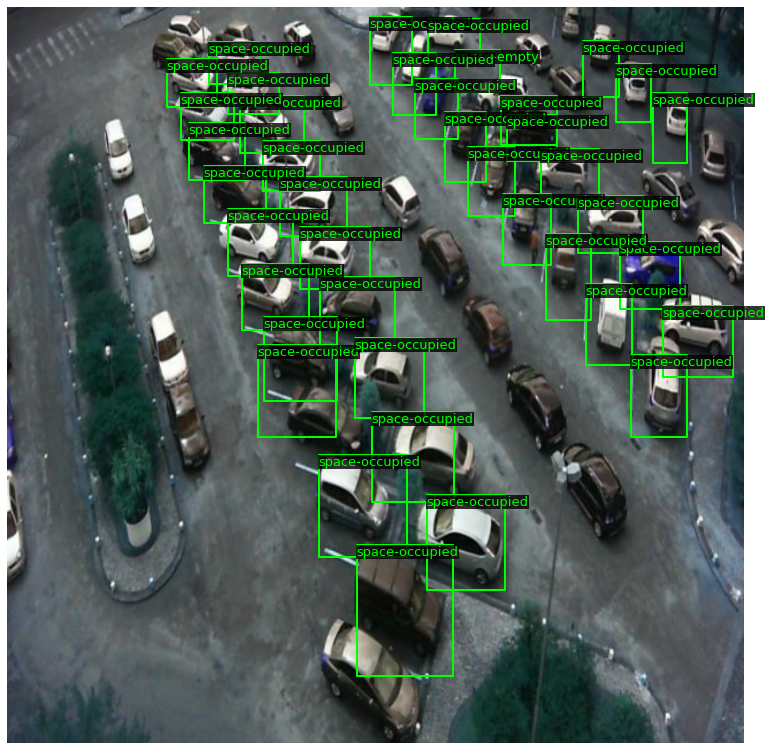

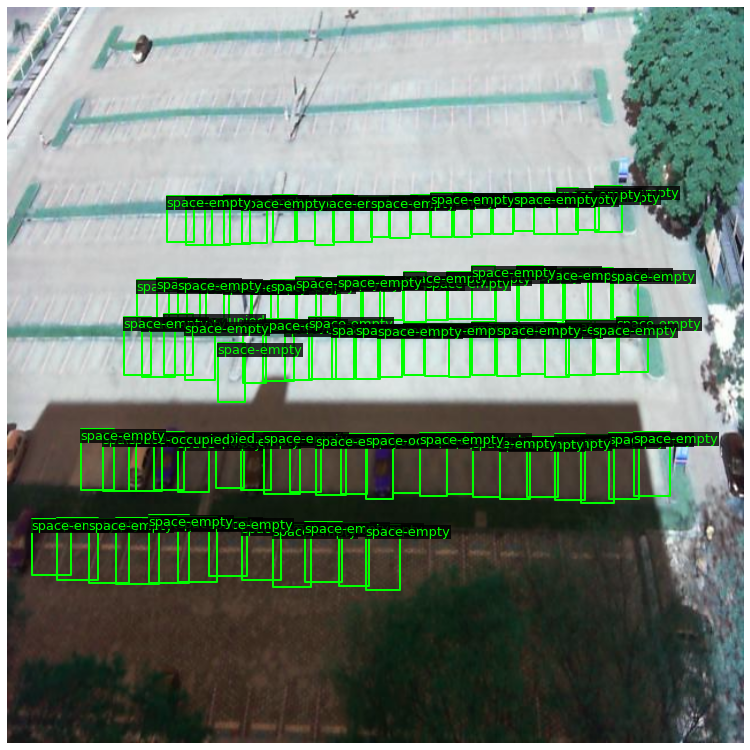

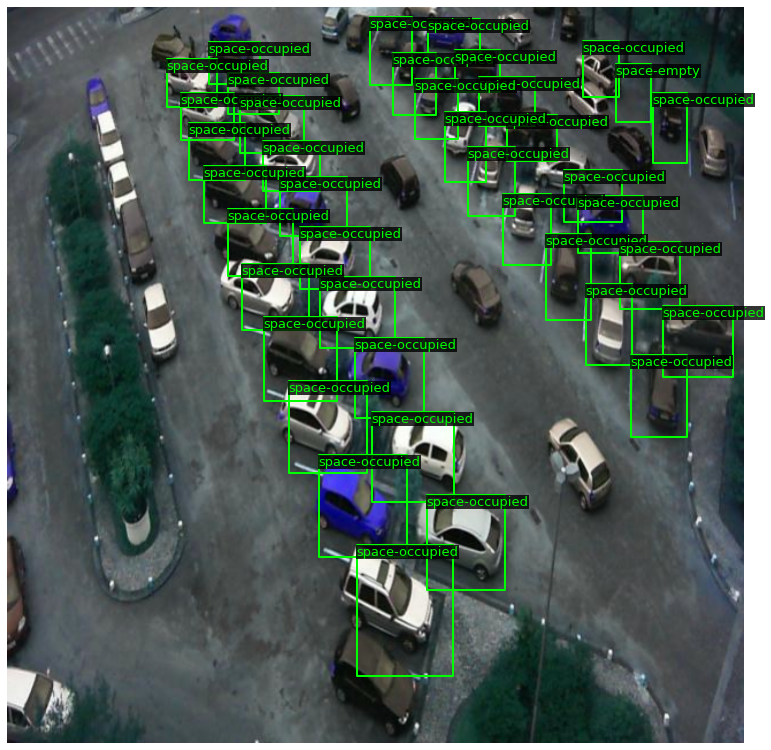

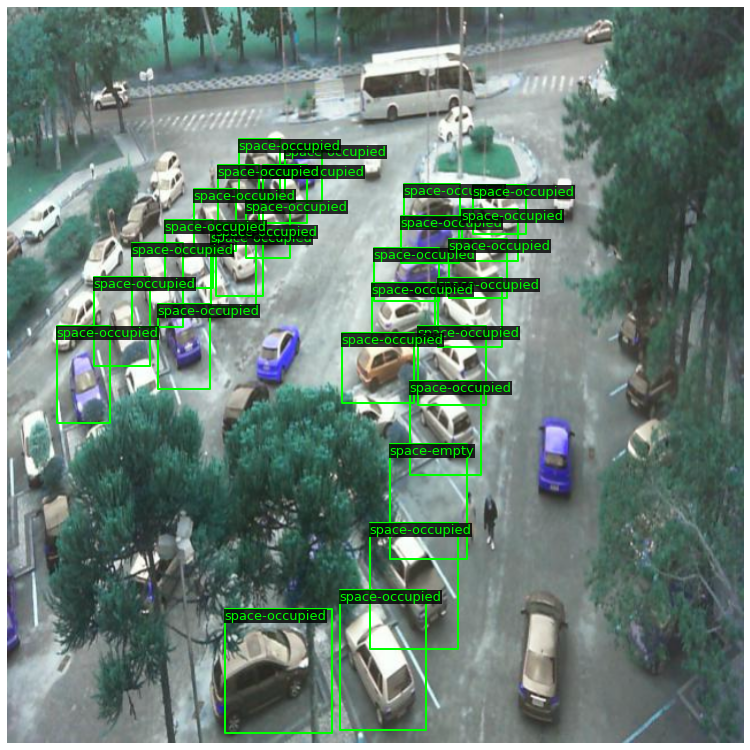

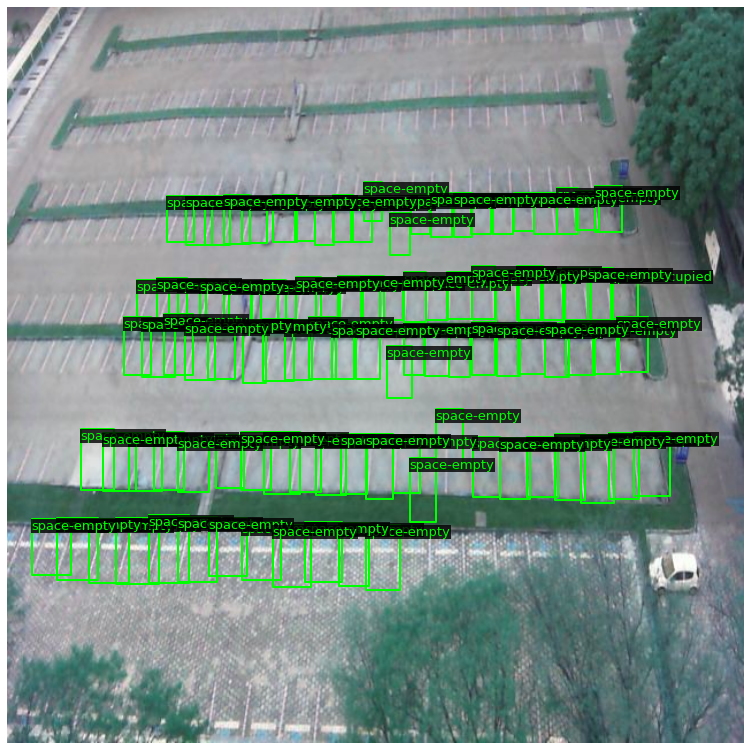

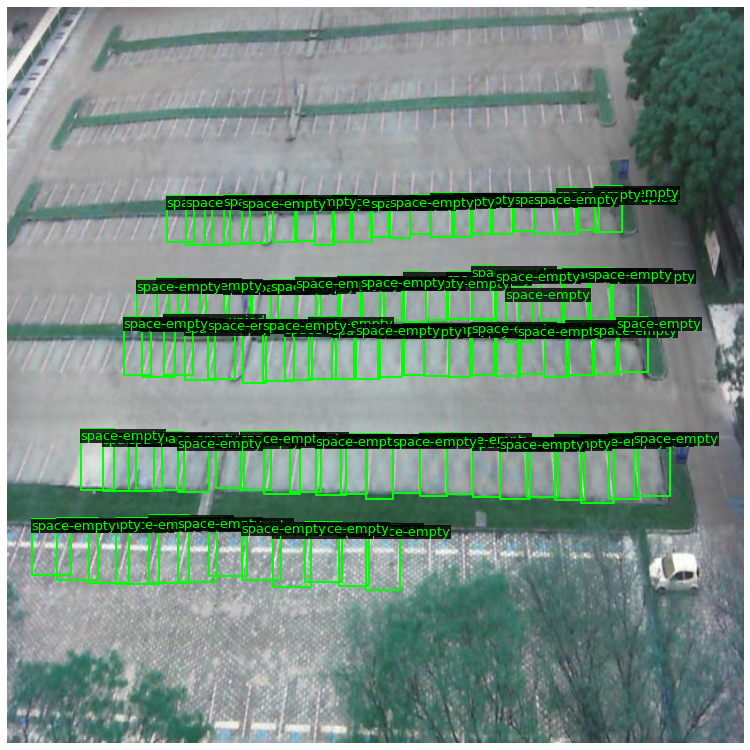

In [12]:
import mmcv
import matplotlib.pyplot as plt
from mmdet.core.visualization import imshow_det_bboxes

cnt = 0
for idx, item in enumerate(dataset):
    if (item["noise_labels"].data == 1).sum() > 0:
        img = item["img"].data.numpy()
        img = np.transpose(img, (1, 2, 0))

        imshow_det_bboxes(
            img=img,
            bboxes=item["gt_bboxes"].data.numpy(),
            labels=item["gt_labels"].data.numpy(),
            class_names=classes
        )
        cnt += 1

    if cnt > 5:
        break

In [ ]:
cnt = 0
for idx, item in enumerate(dataset):
    if (item["noise_labels"].data == 2).sum() > 0:
        img = item["img"].data.numpy()
        img = np.transpose(img, (1, 2, 0))

        imshow_det_bboxes(
            img=img,
            bboxes=item["gt_bboxes"].data.numpy(),
            labels=item["gt_labels"].data.numpy(),
            class_names=classes
        )
        cnt += 1

    if cnt > 5:
        break